In [1]:
%run ../src/start.py


python	3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
---------------------
Versions:
----------------------
pandas      1.1.2
numpy       1.19.1
matplotlib  3.3.1
seaborn     0.11.0
plotly      4.11.0
boto3       1.17.106
awswrangler 2.9.0
----------------------


Loaded Libraries
-------------------
import pandas as pd
import numpy as np
import sys,os
import re
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


## AWS
import boto3
import awswrangler as wr
----------------


GLOBAL VARIABLES
--------------------------
HERE_DIR: list current directory path
RAW_DIR: list files in `data\raw` directory
INTER_DIR: list files in `data\interim` directory
FINAL_DIR: list files in `data\final` directory
SRC_DIR: list files in `src\` directory
------------------------------

# SAVE PLOTS
To save a plot 

## Load Data

In [2]:
# year file
year = '2011'

In [3]:
# helper function
def bucket_raw_path(bucket_name,path_dir):
    ''''''
    raw_path = f's3://{bucket_name}/{path_dir}'
    return raw_path

In [4]:
raw = bucket_raw_path('salas-data',f'capstone/raw-data/crime-data/{year}')
raw

's3://salas-data/capstone/raw-data/crime-data/2011'

## List objects in bucket

In [5]:
wr.s3.list_objects(raw)

['s3://salas-data/capstone/raw-data/crime-data/2011/apr11.xlsx',
 's3://salas-data/capstone/raw-data/crime-data/2011/aug11.xlsx',
 's3://salas-data/capstone/raw-data/crime-data/2011/dec11.xlsx',
 's3://salas-data/capstone/raw-data/crime-data/2011/feb11.xlsx',
 's3://salas-data/capstone/raw-data/crime-data/2011/jan11.xlsx',
 's3://salas-data/capstone/raw-data/crime-data/2011/jul11.xlsx',
 's3://salas-data/capstone/raw-data/crime-data/2011/jun11.xlsx',
 's3://salas-data/capstone/raw-data/crime-data/2011/mar11.xlsx',
 's3://salas-data/capstone/raw-data/crime-data/2011/may11.xlsx',
 's3://salas-data/capstone/raw-data/crime-data/2011/nov11.xlsx',
 's3://salas-data/capstone/raw-data/crime-data/2011/oct11.xlsx',
 's3://salas-data/capstone/raw-data/crime-data/2011/sep11.xlsx']

## Create dataframe from s3 files

In [6]:
def s3_files_to_df(s3_files_path):
    ''' load s3 file path from wr result
    returns a dataframe of concat files '''
    df_list = []
    for i in wr.s3.list_objects(s3_files_path):
        temp = wr.s3.read_excel(i, engine='openpyxl')
        df_list.append(temp)
    # create df from list files
    df = pd.concat(df_list, ignore_index=True)
    return df

In [17]:
%%time
df = s3_files_to_df(raw)

CPU times: user 21.2 s, sys: 78.1 ms, total: 21.3 s
Wall time: 30.2 s


In [18]:
## cleanup columns
df.columns = df.columns.str.lower().str.replace(' ','_').str.replace('\n','_').str.strip()

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127659 entries, 0 to 127658
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   date           127659 non-null  datetime64[ns]
 1   hour           127659 non-null  int64         
 2   offense_type   127659 non-null  object        
 3   beat           127659 non-null  object        
 4   premise        127659 non-null  object        
 5   block_range    127659 non-null  object        
 6   street_name    127659 non-null  object        
 7   type           127659 non-null  object        
 8   suffix         127659 non-null  object        
 9   ._of_offenses  127659 non-null  int64         
 10  field11        0 non-null       float64       
 11  field12        0 non-null       float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(7)
memory usage: 11.7+ MB


In [20]:
df.head()

,date,hour,offense_type,beat,premise,block_range,street_name,type,suffix,._of_offenses,field11,field12
0,2011-04-13,1,Murder,17E40,20A,6400-6499,BANKSIDE,DR,-,1,NaN,NaN
1,2011-04-06,14,Murder,20G30,20A,2900-2999,HAYES,RD,-,1,NaN,NaN
2,2011-01-10,19,Murder,13D20,20R,8400-8499,GLENSCOT,-,-,1,NaN,NaN
3,2011-04-03,23,Murder,19G50,18N,10700-10799,BELLFORT,ST,W,1,NaN,NaN
4,2011-04-17,23,Murder,11H20,20A,2500-2599,BROADWAY,ST,-,1,NaN,NaN


## Show null data

In [21]:
df.apply(lambda x: sum(x.isnull()))

date                  0
hour                  0
offense_type          0
beat                  0
premise               0
block_range           0
street_name           0
type                  0
suffix                0
._of_offenses         0
field11          127659
field12          127659
dtype: int64

In [24]:
# create null percentage of column as dataframe
null_per_df = pd.DataFrame(df.isna().mean().round(4) * 100)
# rename columns
null_per_df.rename(columns={'index': 'col_name', 0: 'null_percent'}, inplace=True)

# filter data <20% null values
per_filter = null_per_df.null_percent<=90
null_per_df[per_filter].sort_values(by='null_percent',ascending=False)

,null_percent
date,0.0
hour,0.0
offense_type,0.0
beat,0.0
premise,0.0
block_range,0.0
street_name,0.0
type,0.0
suffix,0.0
._of_offenses,0.0


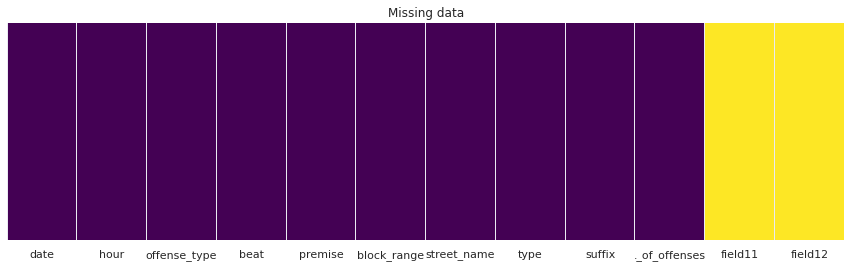

In [23]:
plt.figure(figsize=(15,4))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Missing data')
plt.show()

## Drop unused columns & change name of column

In [25]:
df = df.drop([ 'field11','field12'], axis = 1)
#change column name

df.rename(columns={
    '._of_offenses': 'offenses',
}, inplace=True)

# convert offenses to int

df['offenses'] = df['offenses'].astype('int64')

In [26]:
df.apply(lambda x: sum(x.isnull()))

date            0
hour            0
offense_type    0
beat            0
premise         0
block_range     0
street_name     0
type            0
suffix          0
offenses        0
dtype: int64

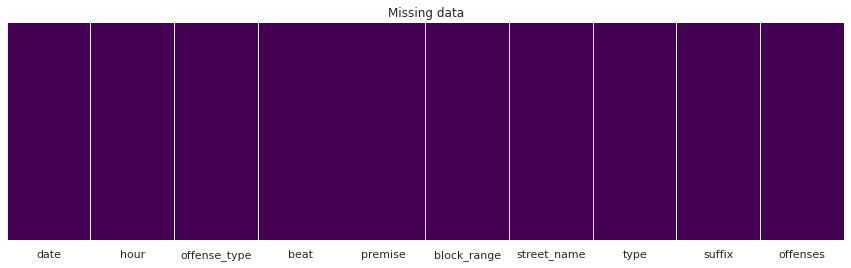

In [27]:
plt.figure(figsize=(15,4))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Missing data')
plt.show()

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127659 entries, 0 to 127658
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          127659 non-null  datetime64[ns]
 1   hour          127659 non-null  int64         
 2   offense_type  127659 non-null  object        
 3   beat          127659 non-null  object        
 4   premise       127659 non-null  object        
 5   block_range   127659 non-null  object        
 6   street_name   127659 non-null  object        
 7   type          127659 non-null  object        
 8   suffix        127659 non-null  object        
 9   offenses      127659 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 9.7+ MB


## Combine columns 

## Combine date & hour to one column

In [29]:
# convert two columns into one datetime
df['date_time'] = pd.to_datetime(df['date']) + pd.to_timedelta(df['hour'], unit='h')

# drop columns
df = df.drop(['date','hour'], axis = 1)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127659 entries, 0 to 127658
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   offense_type  127659 non-null  object        
 1   beat          127659 non-null  object        
 2   premise       127659 non-null  object        
 3   block_range   127659 non-null  object        
 4   street_name   127659 non-null  object        
 5   type          127659 non-null  object        
 6   suffix        127659 non-null  object        
 7   offenses      127659 non-null  int64         
 8   date_time     127659 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 8.8+ MB


In [31]:
df.head()

,offense_type,beat,premise,block_range,street_name,type,suffix,offenses,date_time
0,Murder,17E40,20A,6400-6499,BANKSIDE,DR,-,1,2011-04-13 01:00:00
1,Murder,20G30,20A,2900-2999,HAYES,RD,-,1,2011-04-06 14:00:00
2,Murder,13D20,20R,8400-8499,GLENSCOT,-,-,1,2011-01-10 19:00:00
3,Murder,19G50,18N,10700-10799,BELLFORT,ST,W,1,2011-04-03 23:00:00
4,Murder,11H20,20A,2500-2599,BROADWAY,ST,-,1,2011-04-17 23:00:00


## Convert offenses to integer

In [32]:
# convert offenses to int
df['offenses'] = df['offenses'].astype('int64')

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127659 entries, 0 to 127658
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   offense_type  127659 non-null  object        
 1   beat          127659 non-null  object        
 2   premise       127659 non-null  object        
 3   block_range   127659 non-null  object        
 4   street_name   127659 non-null  object        
 5   type          127659 non-null  object        
 6   suffix        127659 non-null  object        
 7   offenses      127659 non-null  int64         
 8   date_time     127659 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 8.8+ MB


## change order of columns

In [34]:
col_ord =['date_time','offenses','offense_type', 'block_range', 'street_name', 'type', 'suffix','beat', 'premise']
df = df[col_ord]
df.head()

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise
0,2011-04-13 01:00:00,1,Murder,6400-6499,BANKSIDE,DR,-,17E40,20A
1,2011-04-06 14:00:00,1,Murder,2900-2999,HAYES,RD,-,20G30,20A
2,2011-01-10 19:00:00,1,Murder,8400-8499,GLENSCOT,-,-,13D20,20R
3,2011-04-03 23:00:00,1,Murder,10700-10799,BELLFORT,ST,W,19G50,18N
4,2011-04-17 23:00:00,1,Murder,2500-2599,BROADWAY,ST,-,11H20,20A


## Save to bucket

In [35]:
bucket = 'salas-data'
file_name = f'crime_{year}.csv'
path_to_save = f"s3://{bucket}/capstone/inter-data/crime-data/{file_name}"
path_to_save

's3://salas-data/capstone/inter-data/crime-data/crime_2011.csv'

In [36]:
%%time
wr.s3.to_csv(df, path_to_save, index=False)

CPU times: user 453 ms, sys: 125 ms, total: 578 ms
Wall time: 6.95 s


{'paths': ['s3://salas-data/capstone/inter-data/crime-data/crime_2011.csv'],
 'partitions_values': {}}